In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [ ]:
#Hyperparameters for the training and loading

device = "cuda " if torch.cuda.is_available() else "cpu"
lr =2e-4
batch_size = 64
image_size = 64
channel_img = 1
z_dim = 100
num_epochs = 5


In [ ]:
import torch
import torch.nn as nn
from typing import Tuple

original_dim = 784
intermediate_dim = 256
latent_dim = 2

class Encoder(nn.Module):
    def __init__(self, in_features: int, hidden_features: int, latent_features: int):
        super().__init__()

        self.hidden = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            nn.ReLU()
        )

        self.z_mean = nn.Linear(hidden_features, latent_features)
        self.z_log_var = nn.Linear(hidden_features, latent_features)

    def reparameterize(self, mu: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        return mu + epsilon * std

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        h = self.hidden(x)
        mu = self.z_mean(h)
        log_var = self.z_log_var(h)
        z = self.reparameterize(mu, log_var)

        return mu, log_var, z

encoder = Encoder(
    in_features=original_dim,
    hidden_features=intermediate_dim,
    latent_features=latent_dim
)

dummy_input = torch.randn(32, original_dim)

mean, log_variance, z_sample = encoder(dummy_input)

print("Mean shape:", mean.shape)
print("Log Var shape:", log_variance.shape)
print("Z Sample shape:", z_sample.shape)

Mean shape: torch.Size([32, 2])
Log Var shape: torch.Size([32, 2])
Z Sample shape: torch.Size([32, 2])


In [ ]:
def sampling (mean , log_variance):
  epsilon = torch.randn((batch_size, latent_dim) , mean= 0. )
  return mean + torch.exp(log_variance/2) * epsilon

In [ ]:
class Decoder(nn.Module):
  def __init__(self, latent_features:int , hidden_features:int , out_features :int):
    super(). __init__()


    self.decode = nn.Sequential(
        nn.Linear(latent_features, hidden_features),
        nn.ReLU(),

        nn.Linear (hidden_features, out_features),
        nn.Sigmoid()
    )


  def forward (self , z : torch.tensor)-> torch.tensor :
    return self.decode(z)


decoder = Decoder(latent_features=latent_dim ,
                  hidden_features=intermediate_dim,
                  out_features=original_dim)
dummy_z = torch.randn(32 , latent_dim)

reconstructed_x = decoder(dummy_z)
print("Reconstructed X shape:", reconstructed_x.shape) # Expected: torch.Size([32, 784])


Reconstructed X shape: torch.Size([32, 784])


In [ ]:
class VAE(nn.Module):
  def __init__(self , input_features : int, intermediate_features:int, latent_features:int  ):
    super(). __init__()

    self.encoder = Encoder(original_dim , intermediate_dim , latent_dim)
    self.decoder = Decoder (latent_dim , intermediate_dim , original_dim)

  def forward (self , x: torch.tensor ) -> Tuple[torch.tensor , torch.tensor , torch.tensor ]:
     mu , log_variance , z = self.encoder(x)
     reconstruction = self.decoder(z)

     return reconstruction , mu , log_variance

vae_model = VAE(original_dim,intermediate_dim,latent_dim)

dummy_input = torch.randn (32 ,original_dim)
reconstructed_output, mean, log_variance = vae_model(dummy_input)
print("Final Reconstructed Output Shape:", reconstructed_output.shape)




Final Reconstructed Output Shape: torch.Size([32, 784])


In [1]:
%pip install torch-summary

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from torchsummary import summary

# Create an instance of our VAE model and move it to the correct device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_summary = VAE(original_dim, intermediate_dim, latent_dim).to(device)

# Provide the model and the input size (without the batch dimension)
summary(model_summary, input_size=(original_dim,))

Layer (type:depth-idx)                   Param #
├─Encoder: 1-1                           --
|    └─Sequential: 2-1                   --
|    |    └─Linear: 3-1                  200,960
|    |    └─ReLU: 3-2                    --
|    └─Linear: 2-2                       514
|    └─Linear: 2-3                       514
├─Decoder: 1-2                           --
|    └─Sequential: 2-4                   --
|    |    └─Linear: 3-3                  768
|    |    └─ReLU: 3-4                    --
|    |    └─Linear: 3-5                  201,488
|    |    └─Sigmoid: 3-6                 --
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Encoder: 1-1                           --
|    └─Sequential: 2-1                   --
|    |    └─Linear: 3-1                  200,960
|    |    └─ReLU: 3-2                    --
|    └─Linear: 2-2                       514
|    └─Linear: 2-3                       514
├─Decoder: 1-2                           --
|    └─Sequential: 2-4                   --
|    |    └─Linear: 3-3                  768
|    |    └─ReLU: 3-4                    --
|    |    └─Linear: 3-5                  201,488
|    |    └─Sigmoid: 3-6                 --
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0

In [ ]:
loss_fn =  torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vae_model.parameters() , lr = 0.001)

In [ ]:
import torch.nn.functional as F

def vae_loss(x, x_decoded_mean, z_log_var, z_mean, original_dim=original_dim):

    reconstruction_loss = F.binary_cross_entropy(x_decoded_mean, x, reduction='sum')


    kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - torch.exp(z_log_var))

    return reconstruction_loss + kl_loss

In [2]:
%pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import torch.nn.functional as F

NUM_EPOCHS: int = 10
BATCH_SIZE: int = 128
LEARNING_RATE: float = 0.001
original_dim = 784
intermediate_dim = 256
latent_dim = 2


transform_pipeline =  transforms.Compose ([
    transforms.ToTensor(),
    transforms.Lambda(lambda x : torch.flatten(x))

])

train_dataset = datasets.MNIST(root = "dataset", train=True , transform=transform_pipeline , download =True)
test_dataset= datasets.MNIST(root = "dataset", train=False , transform=transform_pipeline , download =True)


train_dataloader = DataLoader(dataset = train_dataset , batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)



images , labels = next(iter(train_dataloader))

device = "cuda:0" if torch.cuda.is_available () else "cpu"
vae_model = VAE(original_dim , intermediate_dim , latent_dim ). to(device)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=LEARNING_RATE)


for epoch in range(NUM_EPOCHS):

  vae_model.train()
  train_loss = 0

  for batch_idx, (images, _) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
    images= images.to(device)




    optimizer.zero_grad()
    reconstruction , mu , log_variance = vae_model(images)


    loss = vae_loss(images , reconstruction , mu , log_variance)

    loss.backward()

    optimizer.step()

    train_loss +=loss.item()




  avg_loss = train_loss / len(train_dataloader.dataset)
  print(f"====> Epoch: {epoch+1} Average loss: {avg_loss:.4f}")

Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 1 Average loss: 201.6819


Epoch 2/10:   0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 2 Average loss: 172.8737


Epoch 3/10:   0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 3 Average loss: 169.0326


Epoch 4/10:   0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 4 Average loss: 166.9238


Epoch 5/10:   0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 5 Average loss: 165.4252


Epoch 6/10:   0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 6 Average loss: 164.0473


Epoch 7/10:   0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 7 Average loss: 162.9408


Epoch 8/10:   0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 8 Average loss: 161.9611


Epoch 9/10:   0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 9 Average loss: 161.2649


Epoch 10/10:   0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 10 Average loss: 160.5506


In [4]:
%pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 621.2 kB/s eta 0:00:13
   -- ------------------------------------- 0.5/8.1 MB 621.2 kB/s eta 0:00:13
   --- ------------------------------------ 0.8/8.1 MB 729.2 kB/s eta 0:00:11
   --- ------------------------------------ 0.8/8.1 MB 729.2 kB/s eta 0:00:11
   ----- ---------------------------------- 1.0/8.1 MB 729.5 kB/s eta 0:00:10
   ----- ---------------------------------- 1.0/8.1 MB 729.5 kB/s eta 0:00:10
   ------ --------------------------------- 1.3/8.1 MB 706.1 kB/s eta 0:00:10
   ------ --------------------------------- 1.3/

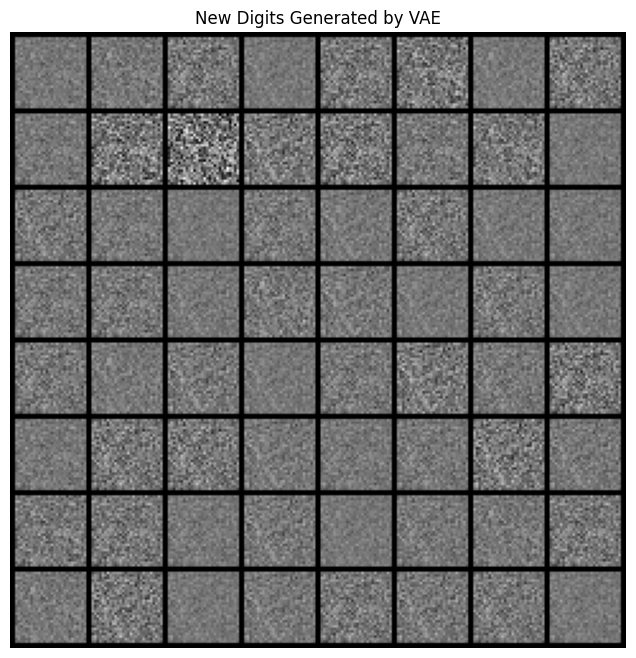

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils


device = "cuda:0" if torch.cuda.is_available () else "cpu"
vae_model = VAE(original_dim , intermediate_dim , latent_dim ). to(device)


vae_model.eval()

num_images_to_generate = 64
latent_dim = 2

with torch.no_grad():
    z_sample = torch.randn(num_images_to_generate, latent_dim).to(device)
    generated_images = vae_model.decoder(z_sample)

generated_images = generated_images.view(num_images_to_generate, 1, 28, 28)

img_grid = vutils.make_grid(generated_images.cpu(), nrow=8, padding=2, normalize=True)

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("New Digits Generated by VAE")
plt.imshow(img_grid.permute(1, 2, 0))
plt.show()

In [ ]:
import matplotlib.pyplot as plt

import numpy as np
import torch.nn as nn
import torch
import torch.functional as F
from torch.utils.data import DataLoader , Dataset


Z_DIM =100
IMG_SHAPE =(1,28,28)



class Generator(nn.Module):
  def __init__(self , img_shape, Z_Dim):
   super(). __init__()

   self.img_shape = img_shape

   self.model =nn.Sequential(
    nn.Linear(Z_Dim , 128 ),
    nn.LeakyReLU(0.01),
    nn.Linear(128 ,28*28*1),
    nn.Tanh()

   )

  def forward (self , z):
    img_flat  = self.model (z)
    img = img_flat.view(img_flat.size(0) , *self.img_shape)
    return img




generator = Generator(img_shape =IMG_SHAPE , Z_Dim =Z_DIM ).to(device)
dummy_noise = torch.randn (64 ,Z_DIM).to(device)
generated_img = generator(dummy_noise)

print(f"Shape of generated images : {generated_img.shape}")

Shape of generated images : torch.Size([64, 1, 28, 28])


In [ ]:
import numpy as np

class Discriminator(nn.Module):

  def __init__(self , img_shape):
    super(). __init__()

    flat_features = int(np.prod(img_shape))

    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(flat_features , 128),
        nn.LeakyReLU(0.01),
        nn.Linear(128 , 1),
        nn.Sigmoid()

    )

  def forward(self , img):
    return self.model(img)


IMG_SHAPE = (1,28,28)
discriminator = Discriminator(img_shape=IMG_SHAPE).to(device)

dummy_img = torch.randn(64 , *IMG_SHAPE).to(device)
prediction = discriminator(dummy_img)
print("Shape of prediction:", prediction.shape)

Shape of prediction: torch.Size([64, 1])


In [ ]:
import torch.optim as optim

class Build_GAN(nn.Module):
  def __init__(self , Generator ,  Discriminator):
    super(). __init__()

    LEARNING_RATE =0.002

    device = "cuda :0" if torch.cuda.is_available() else "cpu"
    discriminator = Discriminator(img_shape=IMG_SHAPE).to(device)
    generator = Generator(img_shape =IMG_SHAPE , Z_Dim =Z_DIM ).to(device)

    criterion = nn.BCELoss()
    opt_disc = optim.Adam(discriminator.parameters(), lr = LEARNING_RATE)
    opt_gen = optim.Adam(generator.parameters(), lr = LEARNING_RATE)




In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

BATCH_SIZE = 128
EPOCHS = 20

transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
]
)


train_dataset = datasets.MNIST(root = "dataset", train=True , transform=transform_pipeline , download =True)
test_dataset= datasets.MNIST(root = "dataset", train=False , transform=transform_pipeline , download =True)


train_dataloader = DataLoader(dataset = train_dataset , batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Epoch [0 / 20 Batch 0 / 469]Loss D :  0.8950 , Loss G :  5.8984


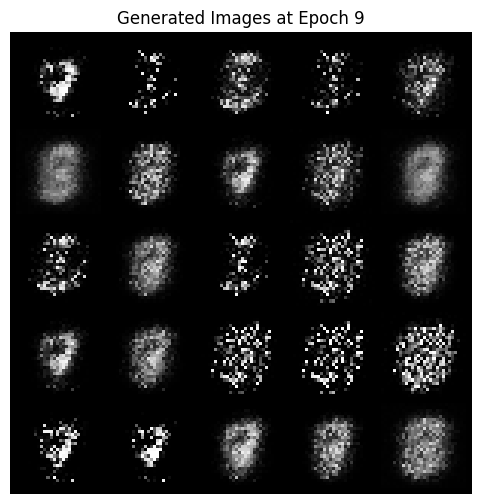

Epoch [0 / 20 Batch 200 / 469]Loss D :  0.9655 , Loss G :  2.9333


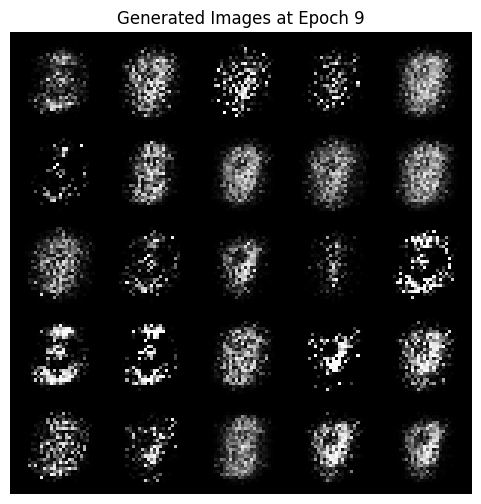

Epoch [0 / 20 Batch 400 / 469]Loss D :  0.3549 , Loss G :  2.4418


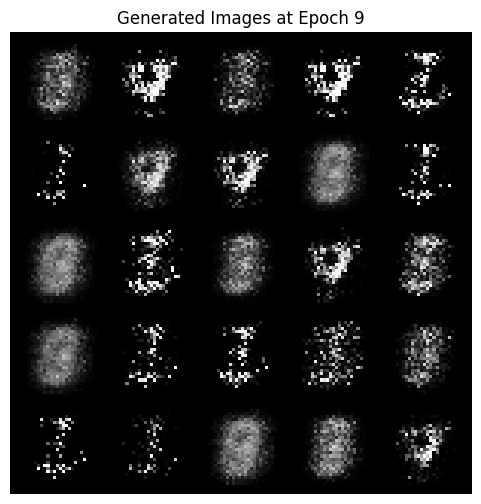

Epoch [1 / 20 Batch 0 / 469]Loss D :  0.3546 , Loss G :  2.3844


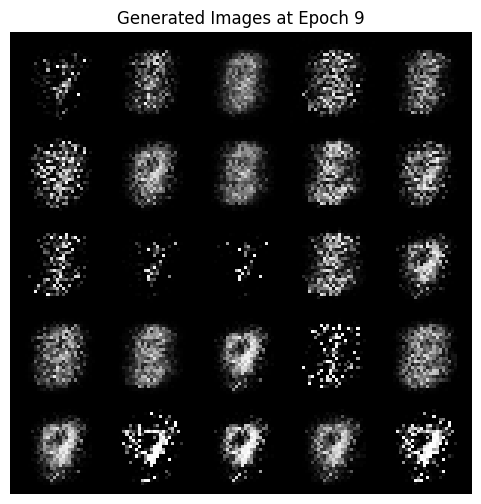

Epoch [1 / 20 Batch 200 / 469]Loss D :  0.4512 , Loss G :  3.7468


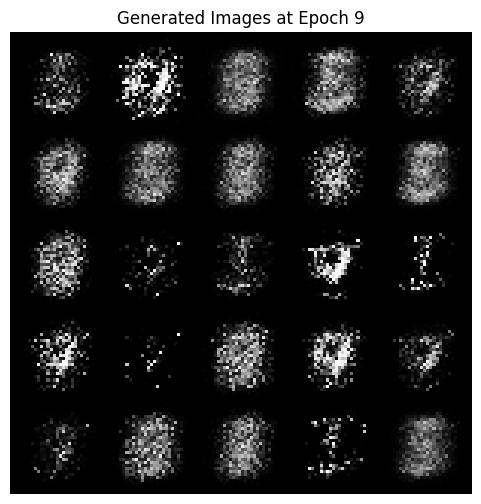

Epoch [1 / 20 Batch 400 / 469]Loss D :  0.5972 , Loss G :  3.5535


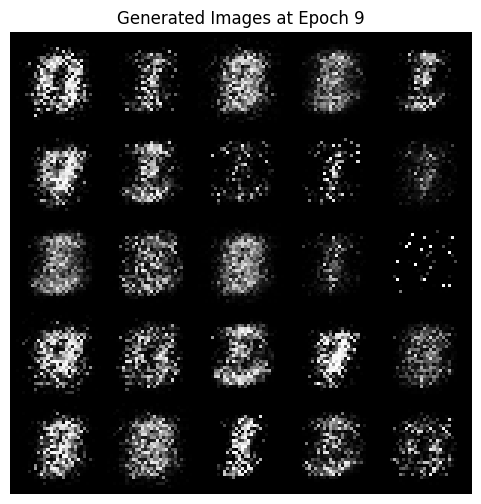

Epoch [2 / 20 Batch 0 / 469]Loss D :  0.2254 , Loss G :  4.2608


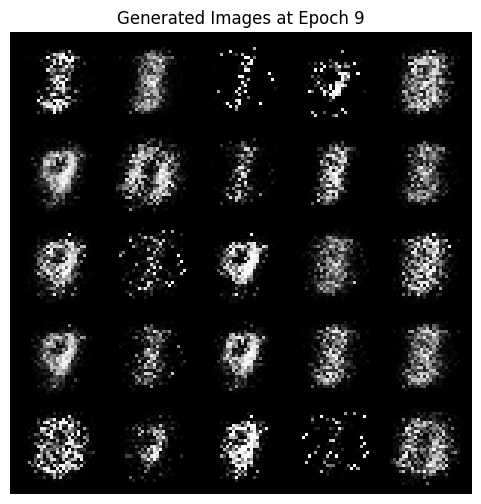

Epoch [2 / 20 Batch 200 / 469]Loss D :  0.3183 , Loss G :  5.2608


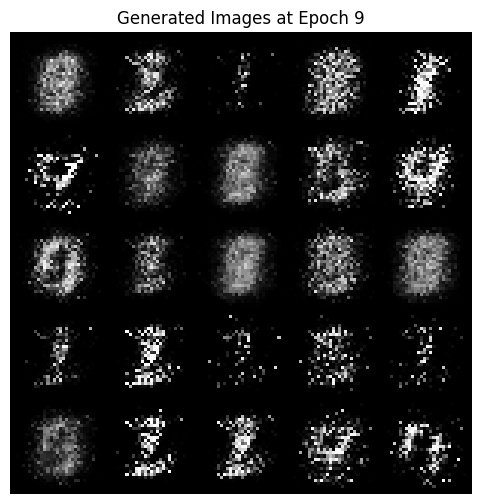

Epoch [2 / 20 Batch 400 / 469]Loss D :  0.6630 , Loss G :  4.2874


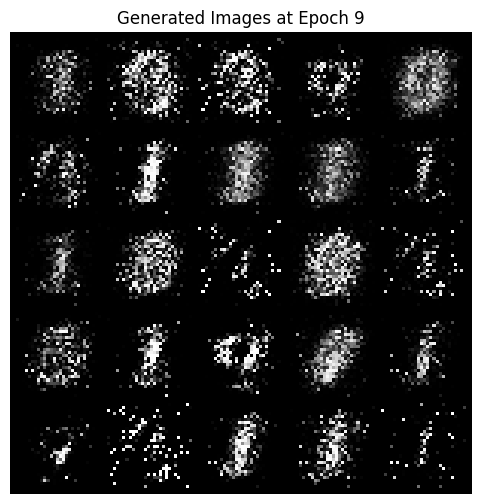

Epoch [3 / 20 Batch 0 / 469]Loss D :  0.3586 , Loss G :  2.6087


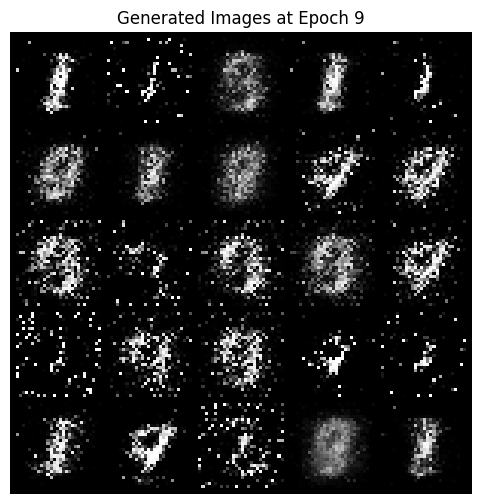

Epoch [3 / 20 Batch 200 / 469]Loss D :  0.3636 , Loss G :  6.0205


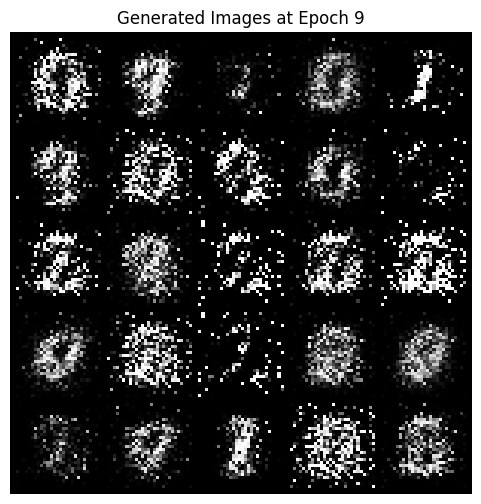

Epoch [3 / 20 Batch 400 / 469]Loss D :  0.2932 , Loss G :  3.5257


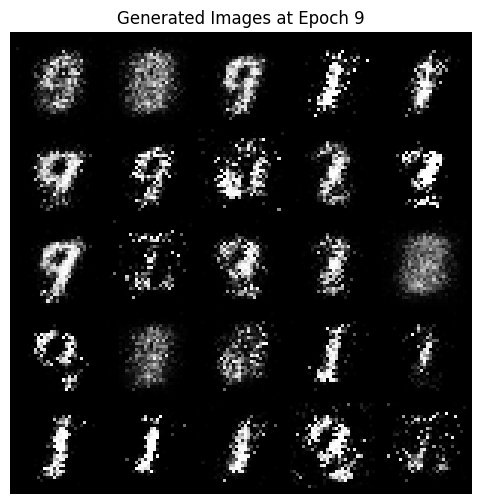

Epoch [4 / 20 Batch 0 / 469]Loss D :  0.3847 , Loss G :  3.4215


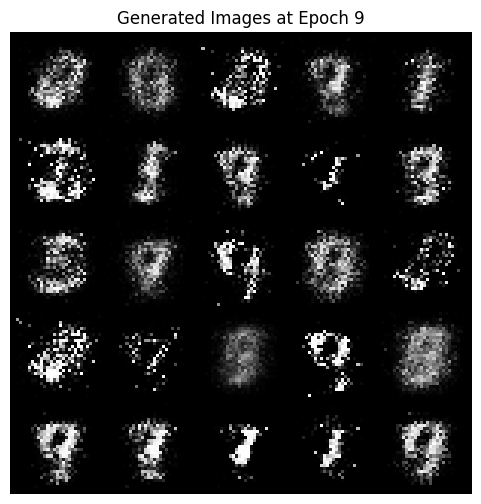

Epoch [4 / 20 Batch 200 / 469]Loss D :  0.6212 , Loss G :  3.4259


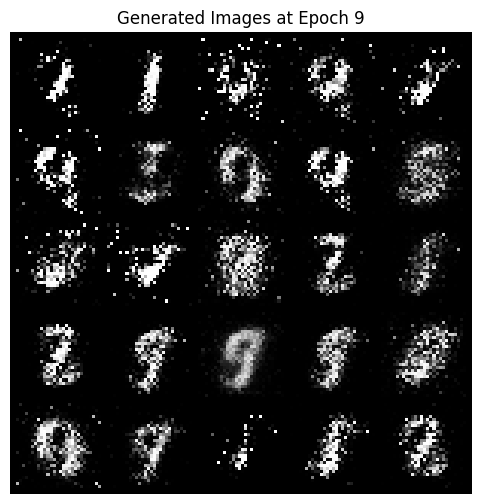

Epoch [4 / 20 Batch 400 / 469]Loss D :  0.4328 , Loss G :  3.4102


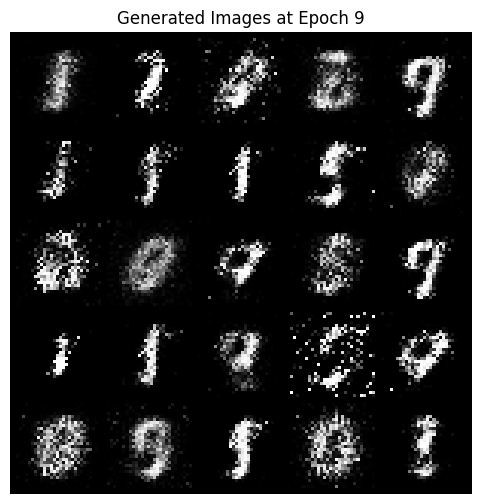

Epoch [5 / 20 Batch 0 / 469]Loss D :  0.5572 , Loss G :  2.4174


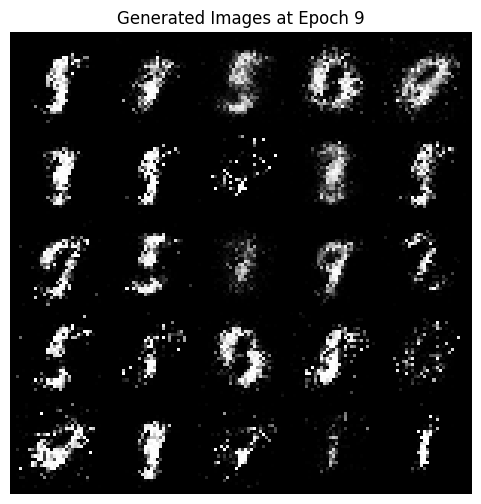

Epoch [5 / 20 Batch 200 / 469]Loss D :  0.4195 , Loss G :  2.4730


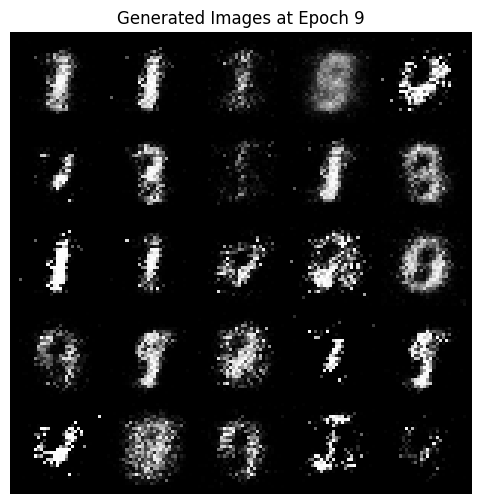

Epoch [5 / 20 Batch 400 / 469]Loss D :  0.5749 , Loss G :  2.7912


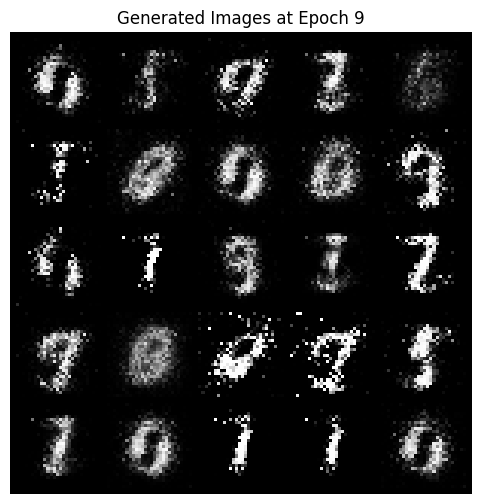

Epoch [6 / 20 Batch 0 / 469]Loss D :  0.4935 , Loss G :  3.0337


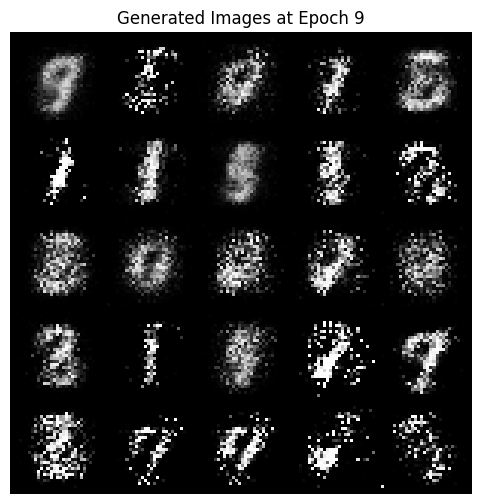

Epoch [6 / 20 Batch 200 / 469]Loss D :  0.4346 , Loss G :  3.6956


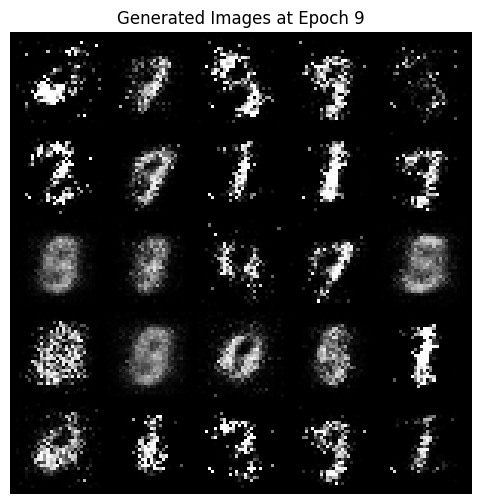

Epoch [6 / 20 Batch 400 / 469]Loss D :  0.2333 , Loss G :  3.2001


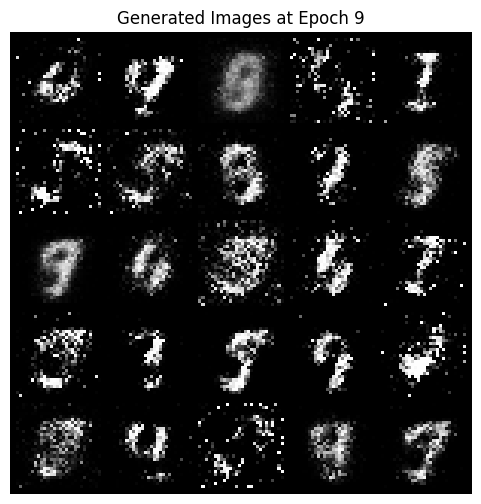

Epoch [7 / 20 Batch 0 / 469]Loss D :  0.3875 , Loss G :  3.0651


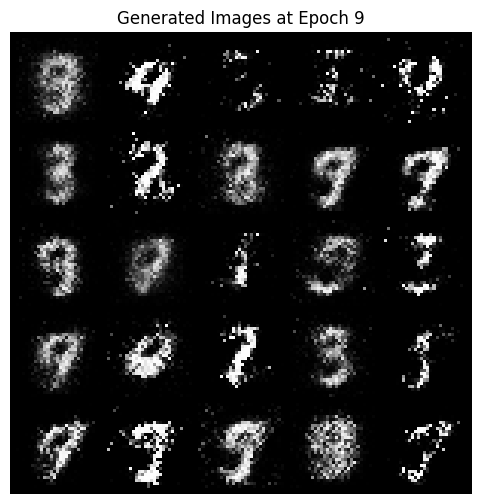

Epoch [7 / 20 Batch 200 / 469]Loss D :  0.3653 , Loss G :  2.9180


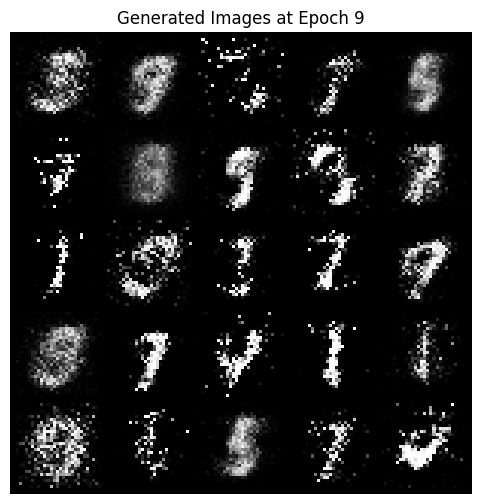

Epoch [7 / 20 Batch 400 / 469]Loss D :  0.5324 , Loss G :  3.0714


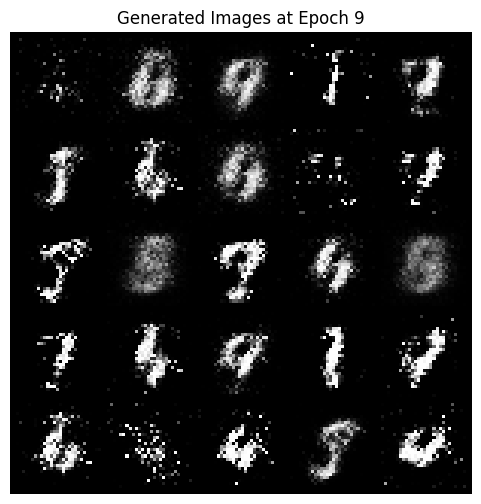

Epoch [8 / 20 Batch 0 / 469]Loss D :  0.2786 , Loss G :  3.9090


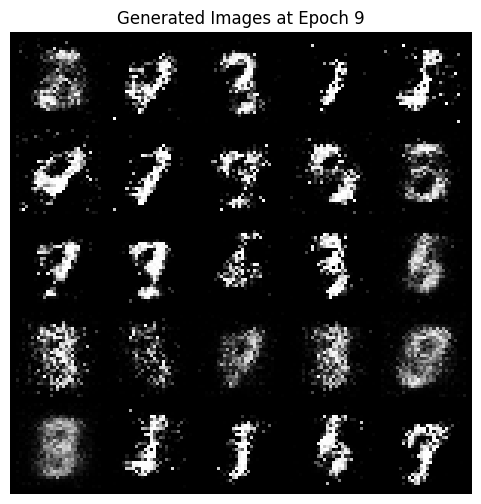

Epoch [8 / 20 Batch 200 / 469]Loss D :  0.4323 , Loss G :  2.7635


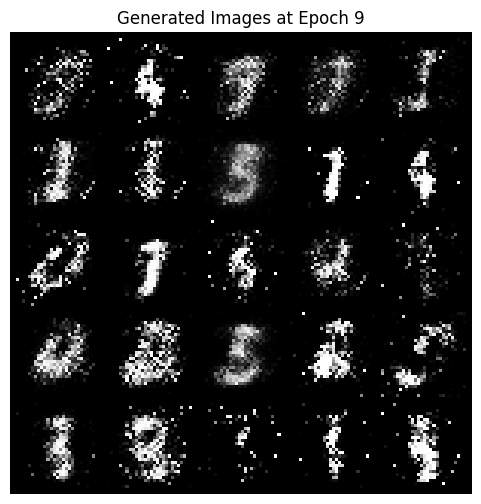

Epoch [8 / 20 Batch 400 / 469]Loss D :  0.4489 , Loss G :  2.5637


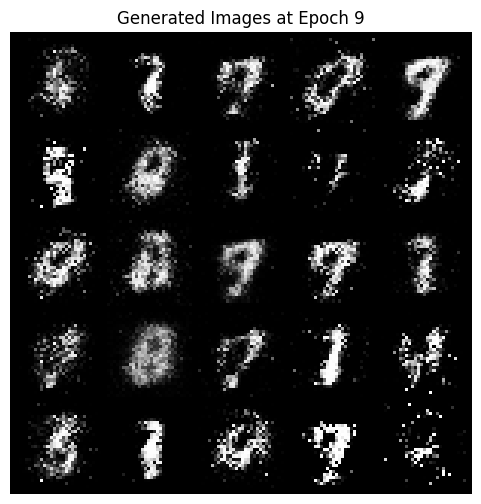

Epoch [9 / 20 Batch 0 / 469]Loss D :  0.5658 , Loss G :  1.6859


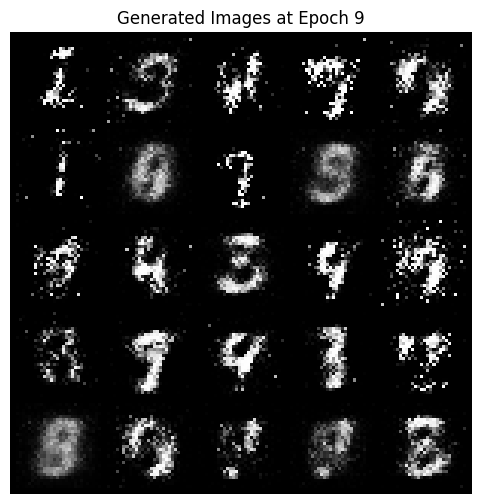

Epoch [9 / 20 Batch 200 / 469]Loss D :  0.7069 , Loss G :  2.0015


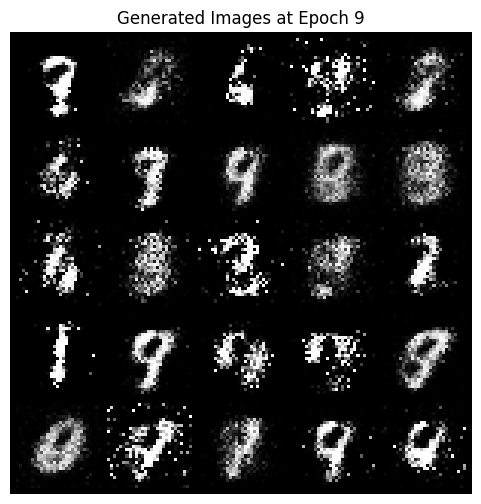

Epoch [9 / 20 Batch 400 / 469]Loss D :  0.2894 , Loss G :  2.6403


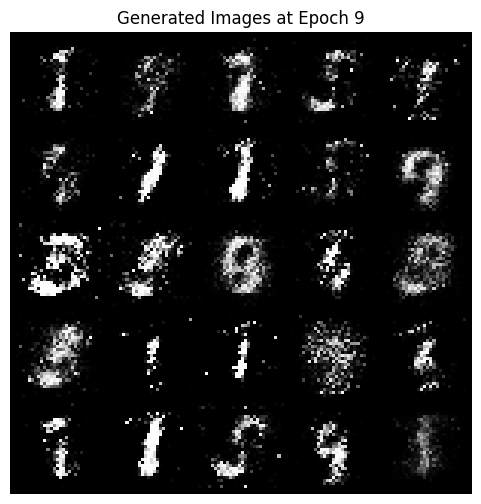

Epoch [10 / 20 Batch 0 / 469]Loss D :  0.4533 , Loss G :  2.7444


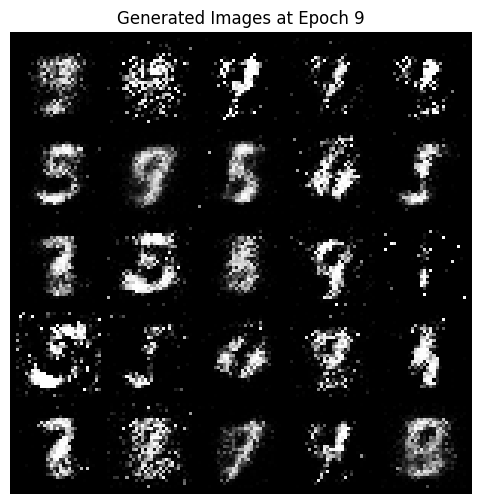

Epoch [10 / 20 Batch 200 / 469]Loss D :  0.6492 , Loss G :  2.4844


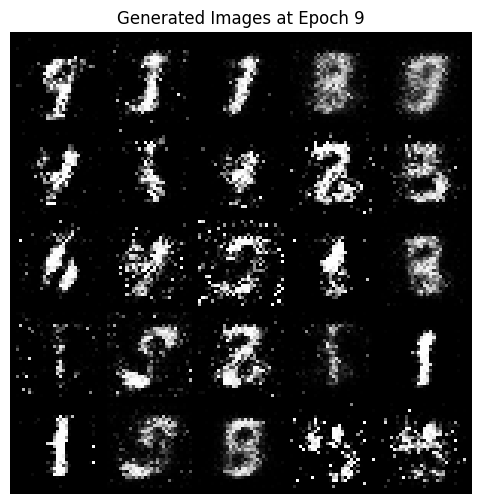

Epoch [10 / 20 Batch 400 / 469]Loss D :  0.6075 , Loss G :  1.8820


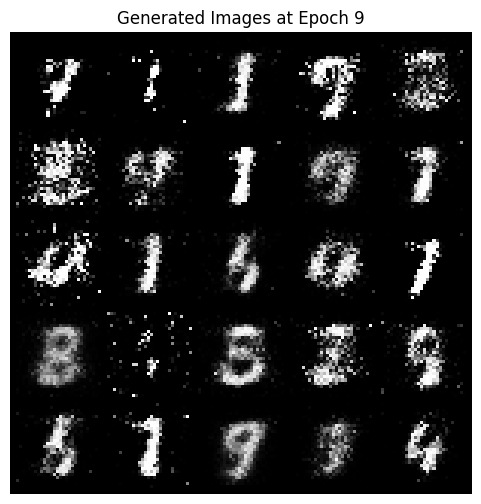

Epoch [11 / 20 Batch 0 / 469]Loss D :  0.5083 , Loss G :  2.5427


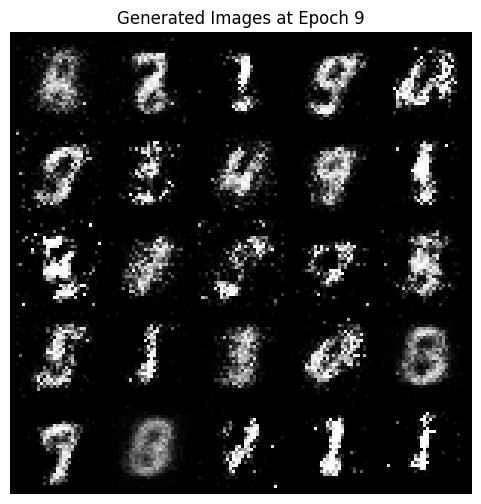

Epoch [11 / 20 Batch 200 / 469]Loss D :  0.6951 , Loss G :  1.8998


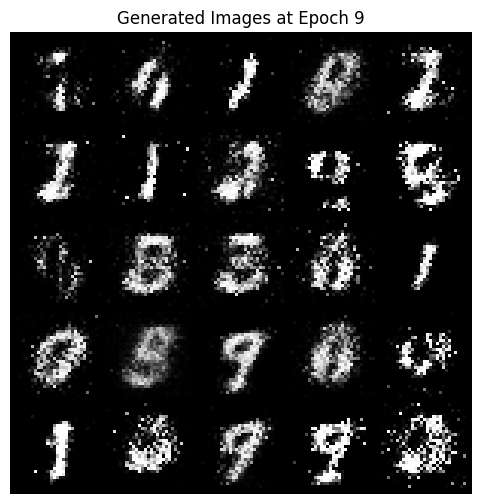

Epoch [11 / 20 Batch 400 / 469]Loss D :  0.4631 , Loss G :  2.1192


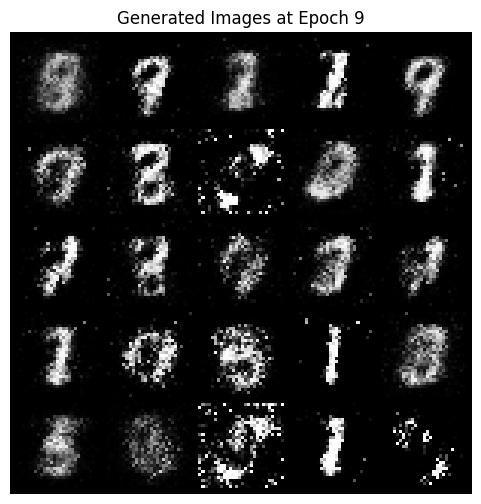

Epoch [12 / 20 Batch 0 / 469]Loss D :  0.4037 , Loss G :  3.0536


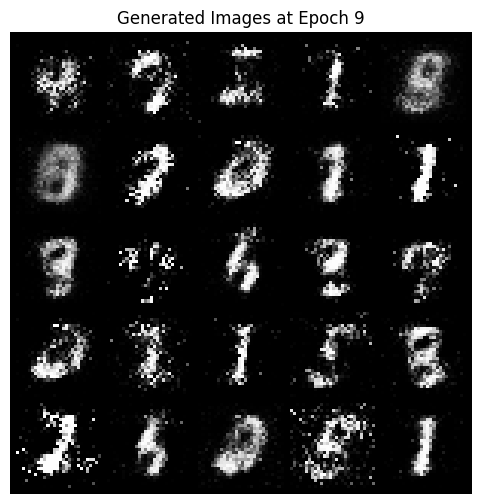

Epoch [12 / 20 Batch 200 / 469]Loss D :  0.3329 , Loss G :  2.8281


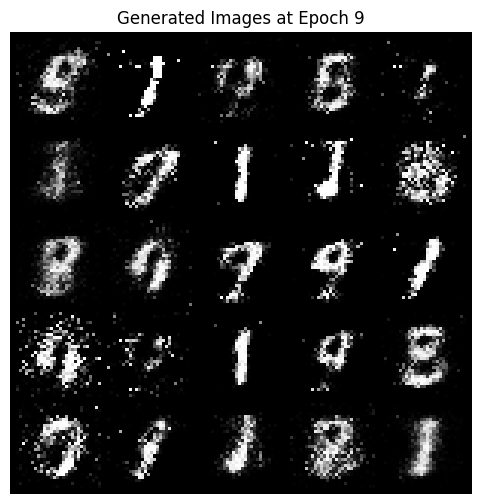

Epoch [12 / 20 Batch 400 / 469]Loss D :  0.4023 , Loss G :  2.6313


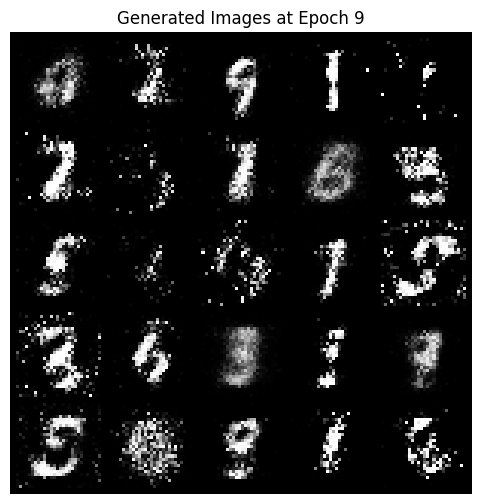

Epoch [13 / 20 Batch 0 / 469]Loss D :  0.3587 , Loss G :  3.6019


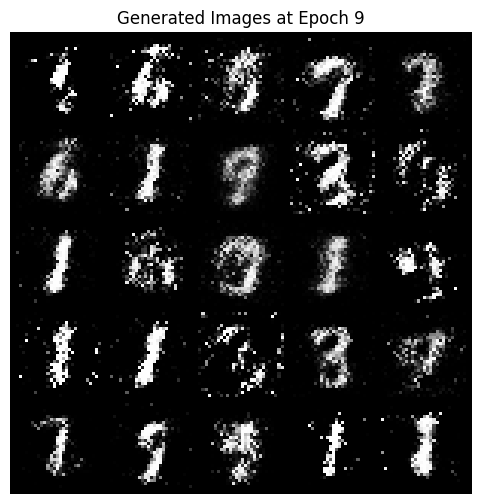

Epoch [13 / 20 Batch 200 / 469]Loss D :  0.4527 , Loss G :  3.0299


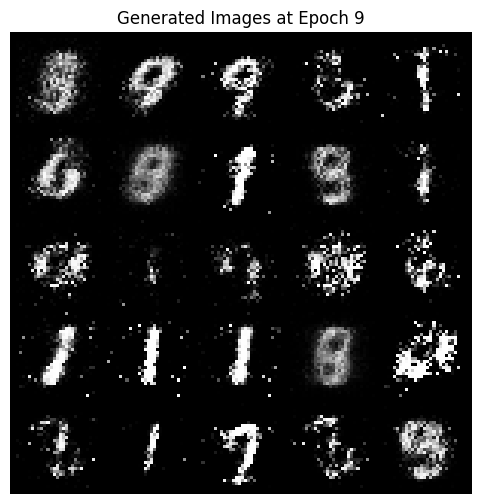

Epoch [13 / 20 Batch 400 / 469]Loss D :  0.4396 , Loss G :  2.6851


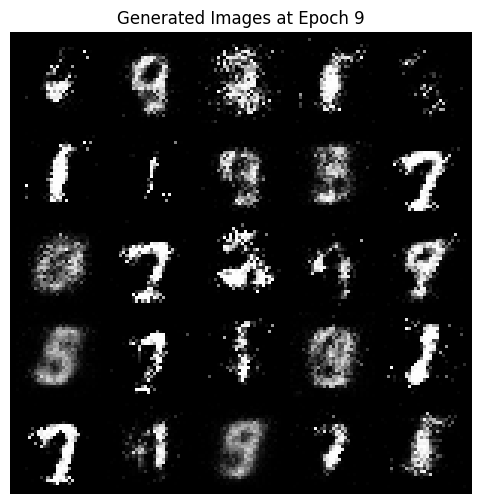

Epoch [14 / 20 Batch 0 / 469]Loss D :  0.3948 , Loss G :  2.6051


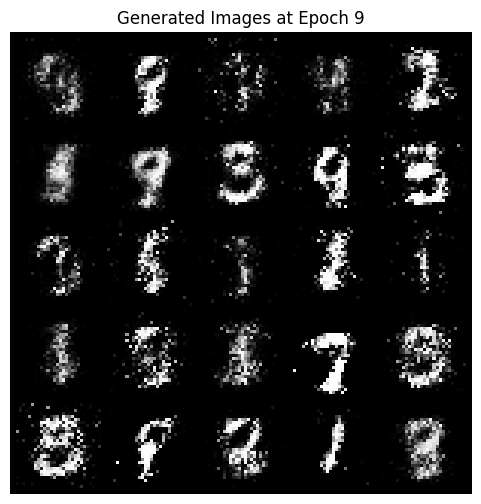

Epoch [14 / 20 Batch 200 / 469]Loss D :  0.3087 , Loss G :  3.1457


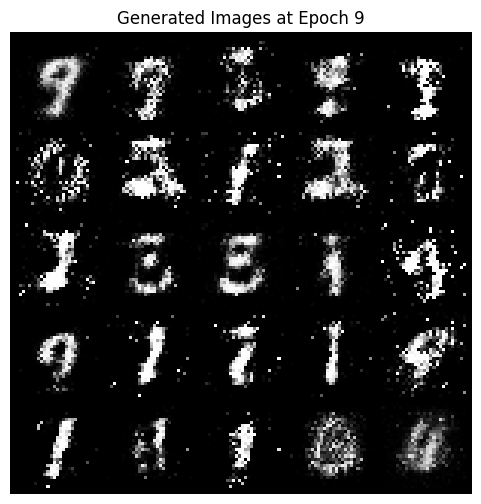

Epoch [14 / 20 Batch 400 / 469]Loss D :  0.4656 , Loss G :  3.0524


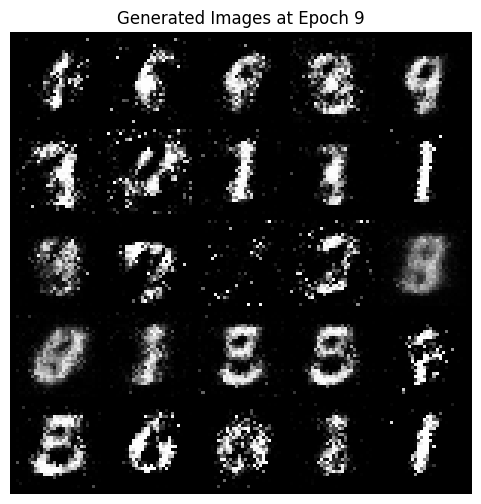

Epoch [15 / 20 Batch 0 / 469]Loss D :  0.3413 , Loss G :  2.3750


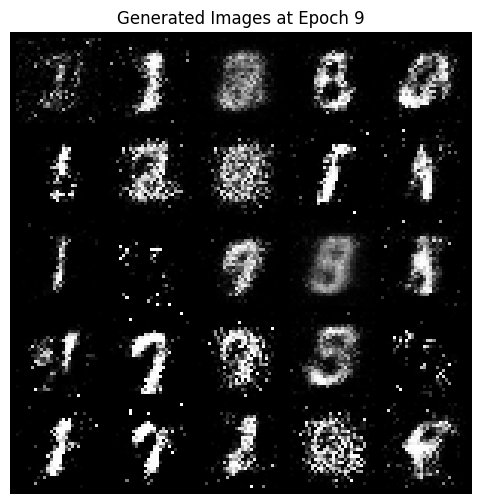

Epoch [15 / 20 Batch 200 / 469]Loss D :  0.4019 , Loss G :  3.1498


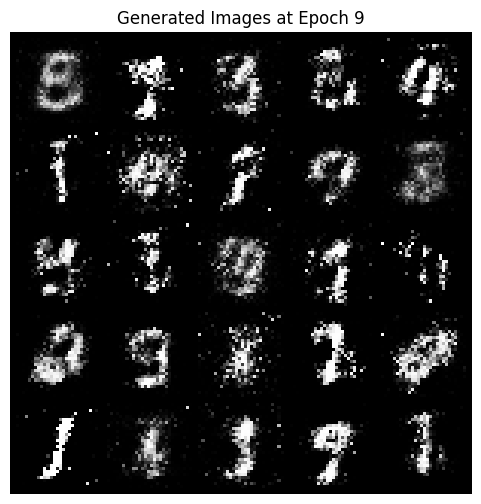

Epoch [15 / 20 Batch 400 / 469]Loss D :  0.4320 , Loss G :  2.1256


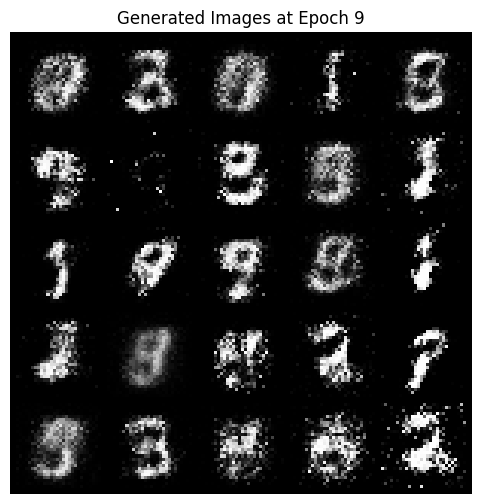

Epoch [16 / 20 Batch 0 / 469]Loss D :  0.5746 , Loss G :  1.5770


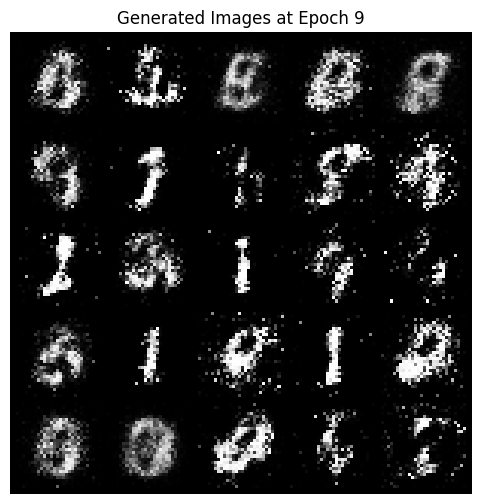

Epoch [16 / 20 Batch 200 / 469]Loss D :  0.4498 , Loss G :  2.3018


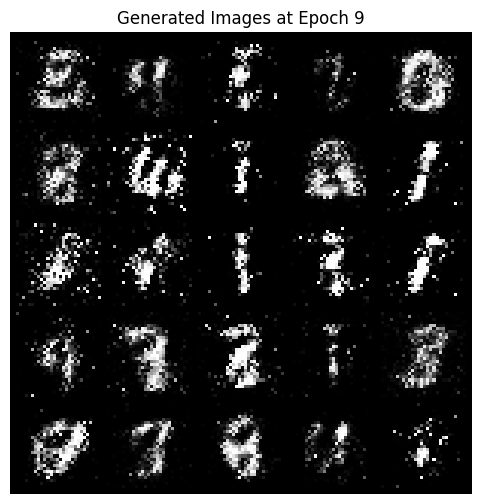

Epoch [16 / 20 Batch 400 / 469]Loss D :  0.5200 , Loss G :  2.6462


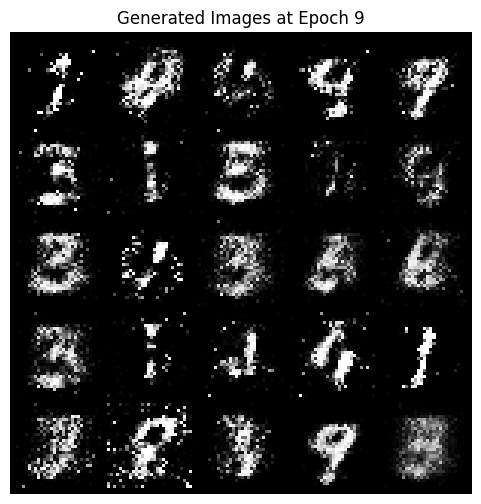

Epoch [17 / 20 Batch 0 / 469]Loss D :  0.4259 , Loss G :  2.7388


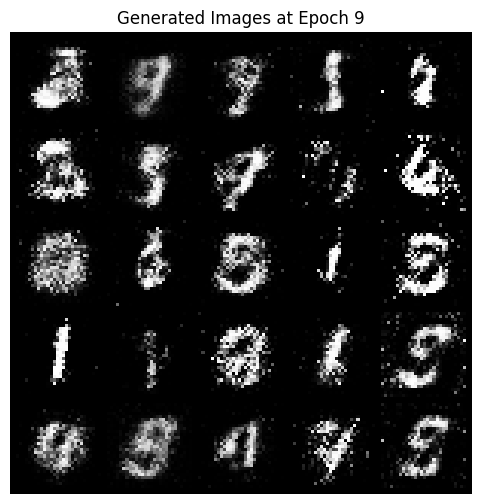

Epoch [17 / 20 Batch 200 / 469]Loss D :  0.4867 , Loss G :  1.7944


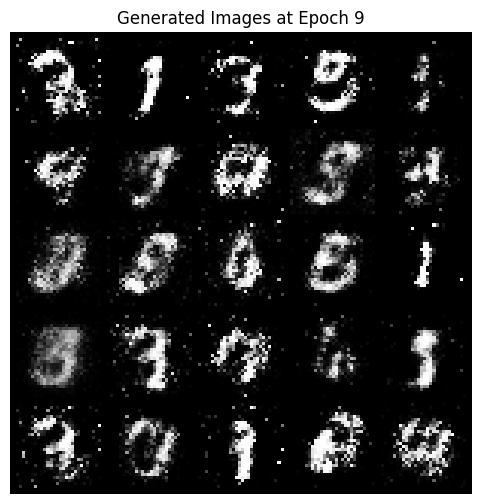

Epoch [17 / 20 Batch 400 / 469]Loss D :  0.4446 , Loss G :  2.8486


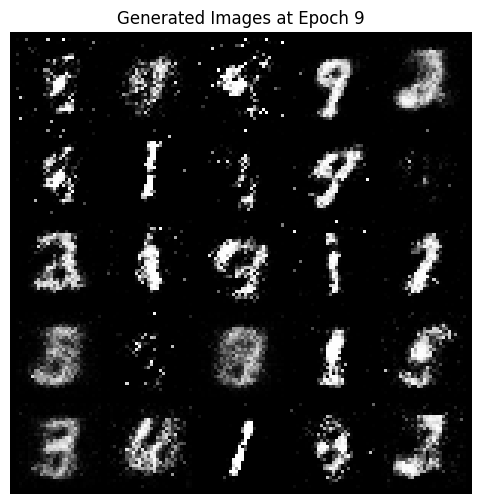

Epoch [18 / 20 Batch 0 / 469]Loss D :  0.2792 , Loss G :  2.6894


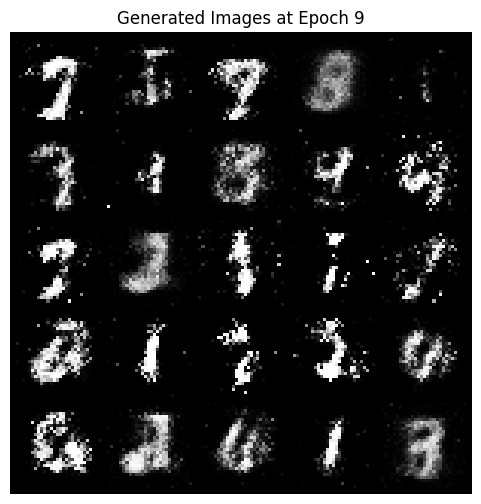

Epoch [18 / 20 Batch 200 / 469]Loss D :  0.6680 , Loss G :  2.3413


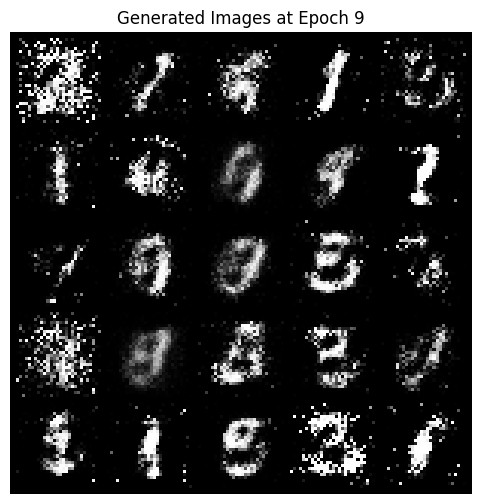

Epoch [18 / 20 Batch 400 / 469]Loss D :  0.6028 , Loss G :  1.4896


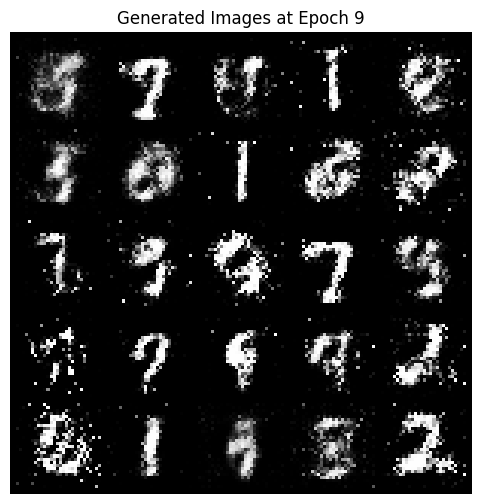

Epoch [19 / 20 Batch 0 / 469]Loss D :  0.3986 , Loss G :  2.4155


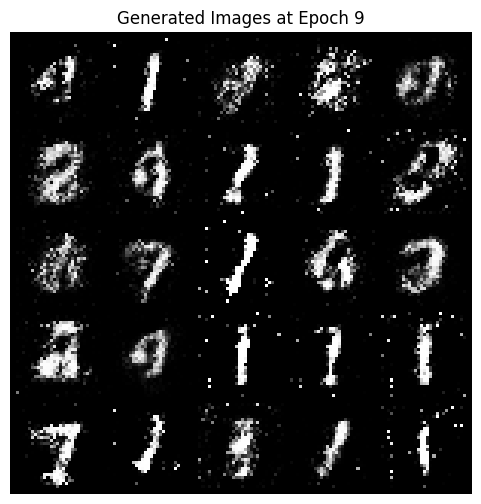

Epoch [19 / 20 Batch 200 / 469]Loss D :  0.4039 , Loss G :  2.7488


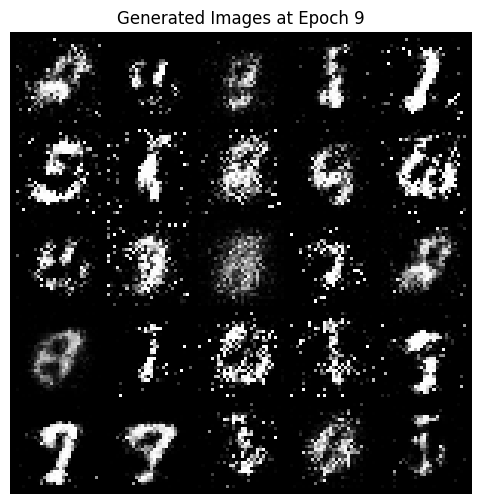

Epoch [19 / 20 Batch 400 / 469]Loss D :  0.4367 , Loss G :  2.3133


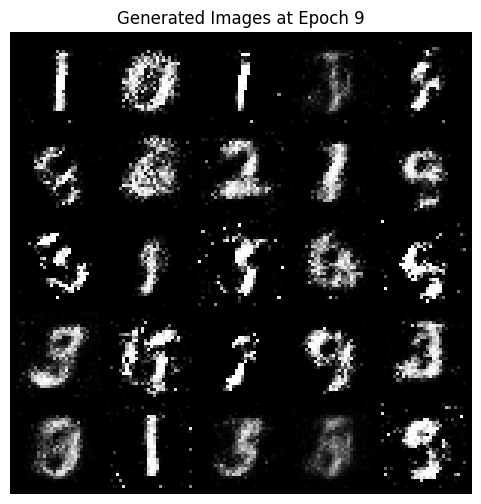

In [ ]:
import torch.optim as optim
import torch.nn as nn

LEARNING_RATE =0.002
criterion = nn.BCELoss()
opt_disc = optim.Adam(discriminator.parameters(), lr = LEARNING_RATE)
opt_gen = optim.Adam(generator.parameters(), lr = LEARNING_RATE)


for epochs in range(EPOCHS):

  for batch_idx , (real_imgs , _) in enumerate(train_dataloader):
    real_imgs = real_imgs . to(device)
    batch_size = real_imgs.size(0)

    real_labels = torch.ones (batch_size, 1).to (device)
    fake_labels = torch.zeros(batch_size , 1). to (device)
#DISCRIMINATOR'S TRAINING.
#START BY GENERATING FAKE IMAGES
    noise = torch.randn(batch_size , Z_DIM).to(device)
    fake_images = generator(noise)


    #Training on real images

    disc_real_pred =discriminator(real_imgs)
    loss_disc_real = criterion(disc_real_pred , real_labels)

    #Training on fake images

    disc_fake_pred= discriminator(fake_images.detach())
    loss_disc_fake = criterion (disc_fake_pred , fake_labels)


    loss_disc = (loss_disc_fake + loss_disc_real) / 2
    discriminator.zero_grad()
    loss_disc.backward()
    opt_disc.step()


    #Train the generator

    output = discriminator (fake_images)
    loss_gen = criterion(output , real_labels)

    generator.zero_grad()
    loss_gen.backward()
    opt_gen.step()


    if batch_idx % 200 == 0 :
      print(
          f"Epoch [{epochs} / {EPOCHS} Batch {batch_idx} / {len(train_dataloader)}]"
          f"Loss D : {loss_disc.item() : .4f} , Loss G : {loss_gen.item(): .4f}"
      )
      sample_images(generator, epoch, Z_DIM, device)

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from pathlib import Path

# Create a directory to save the generated images
Path("generated_images").mkdir(exist_ok=True)

def sample_images(generator, epoch: int, z_dim: int, device: str):
    """
    Generates and saves a grid of images from the generator.

    Args:
        generator (nn.Module): The trained generator model.
        epoch (int): The current epoch number (used for the filename).
        z_dim (int): The dimension of the latent space.
        device (str): The device to run the model on ('cuda' or 'cpu').
    """

    generator.eval()


    num_images = 25


    noise = torch.randn(num_images, z_dim).to(device)

    # Disable gradient calculation
    with torch.no_grad():

        fake_images = generator(noise)




    # normalize=True scales the [-1, 1] output to [0, 1] for display.
    img_grid = vutils.make_grid(fake_images.cpu(), nrow=5, normalize=True)


    plt.figure(figsize=(6, 6))
    plt.axis("off")
    plt.title(f"Generated Images at Epoch {epoch}")
    plt.imshow(img_grid.permute(1, 2, 0))


    plt.savefig(f"generated_images/epoch_{epoch}.png")
    plt.show()

    # Set the generator back to training mode
    generator.train()

Implemeneting Deep GANs

In [ ]:
import torch.nn as nn

class deep_gen(nn.Module):
  def __init__(self , Z_dim):
    super(). __init__()

    self.initial_block = nn.Sequential(
        nn.Linear(Z_dim , 256 *7 *7),


    )

    self. upsample_block = nn.Sequential (
        nn.ConvTranspose2d(256 , 128 , kernel_size =3, stride =2 ,  padding =1 , output_padding = 1),
        nn.BatchNorm2d (128),
        nn.LeakyReLU(0.01),


        nn.ConvTranspose2d (128 , 64 ,kernel_size =3 , stride =1 , padding =1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.01),



        nn.ConvTranspose2d(64 , 1 , kernel_size =3, stride =2 ,  padding =1 , output_padding = 1),
        nn.Tanh()

    )

  def forward (self , Z):
    x = self.initial_block(Z)

    x= x.view(x.size(0), 256 ,7 , 7)
    img = self. upsample_block(x)

    return img

In [ ]:
class deep_disc(nn.Module):
  def __init__(self , img_Shape):
    super().__init__()

    channels , _ , _ = img_Shape


    self.downsample_block = nn.Sequential(
       nn.Conv2d(channels  , 32 , kernel_size= 3 , stride = 2 , padding =1),
       nn.LeakyReLU(0.01),


       nn.Conv2d(32 , 64 , kernel_size= 3 , stride =2 , padding =1),
       nn.BatchNorm2d(64),
       nn.LeakyReLU(0.01),

      nn.Conv2d(64 , 128 , kernel_size = 3 , stride =2 , padding =1),
       nn.BatchNorm2d(128),
       nn.LeakyReLU(0.01),


       nn.Flatten(),


       nn.Linear(128 * 4 * 4 , 1),
       nn.Sigmoid()

    )


  def forward(self , img):
    return self.downsample_block(img)

In [ ]:
import torch.optim as optim

class Build_DCGAN(nn.Module):
  def __init__(self , deep_gen ,  deep_disc):
    super(). __init__()

    LEARNING_RATE =0.002

    device = "cuda :0" if torch.cuda.is_available() else "cpu"
    deep_discr = deep_disc(img_shape=IMG_SHAPE).to(device)
    deep_genr = deep_gen(img_Shape =IMG_SHAPE , Z_dim =Z_DIM ).to(device)

    criterion = nn.BCELoss()
    opt_disc = optim.Adam(deep_disc.parameters(), lr = LEARNING_RATE)
    opt_gen = optim.Adam(deep_gen.parameters(), lr = LEARNING_RATE)

🚀 Starting Training...
Epoch [1/50] | D Loss: 0.3230 | G Loss: 1.1923
Epoch [2/50] | D Loss: 0.3078 | G Loss: 1.4018
Epoch [3/50] | D Loss: 0.3107 | G Loss: 1.8481
Epoch [4/50] | D Loss: 0.3685 | G Loss: 2.2384
Epoch [5/50] | D Loss: 0.3121 | G Loss: 1.2146


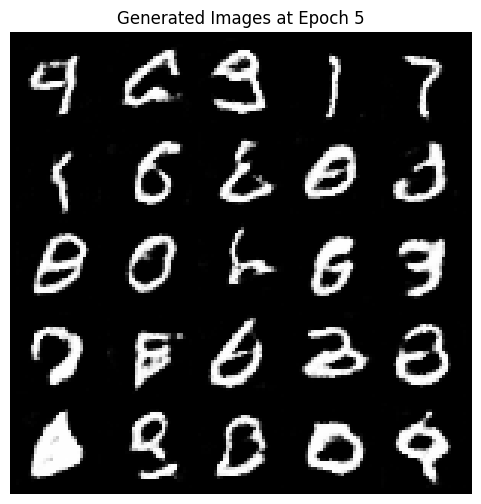

Epoch [6/50] | D Loss: 0.3233 | G Loss: 1.3687
Epoch [7/50] | D Loss: 0.3087 | G Loss: 1.8765
Epoch [8/50] | D Loss: 0.4806 | G Loss: 3.6067
Epoch [9/50] | D Loss: 0.3638 | G Loss: 0.6175
Epoch [10/50] | D Loss: 0.2541 | G Loss: 1.7902


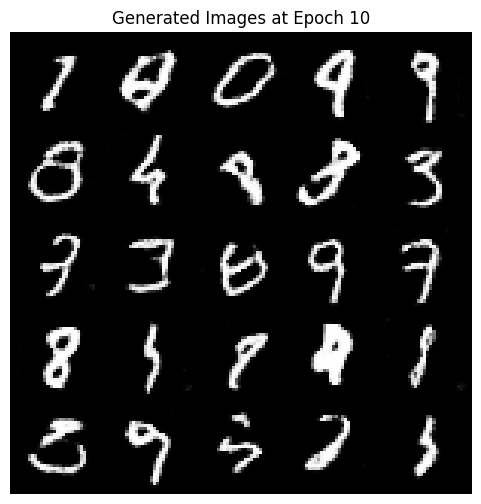

Epoch [11/50] | D Loss: 0.3186 | G Loss: 1.6113
Epoch [12/50] | D Loss: 0.2177 | G Loss: 2.1815
Epoch [13/50] | D Loss: 0.1681 | G Loss: 2.2755
Epoch [14/50] | D Loss: 0.1753 | G Loss: 2.5114
Epoch [15/50] | D Loss: 0.2908 | G Loss: 3.4034


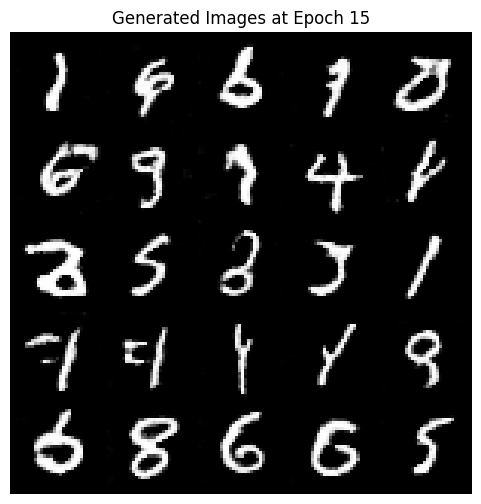

Epoch [16/50] | D Loss: 0.1949 | G Loss: 2.2153
Epoch [17/50] | D Loss: 0.2595 | G Loss: 2.1701
Epoch [18/50] | D Loss: 0.1880 | G Loss: 3.1284
Epoch [19/50] | D Loss: 0.1619 | G Loss: 2.3698
Epoch [20/50] | D Loss: 0.1608 | G Loss: 2.5966


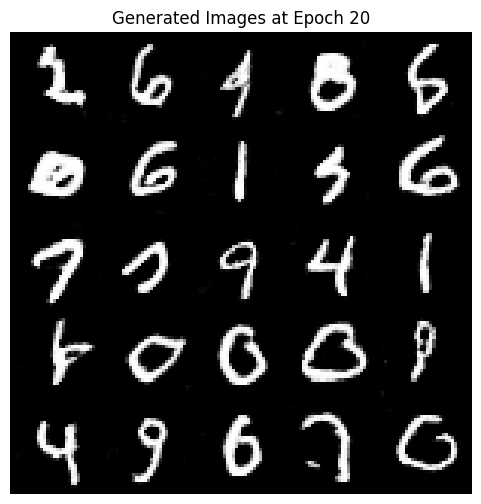

Epoch [21/50] | D Loss: 0.1356 | G Loss: 3.1828
Epoch [22/50] | D Loss: 0.1579 | G Loss: 2.8112
Epoch [23/50] | D Loss: 0.1503 | G Loss: 3.3733
Epoch [24/50] | D Loss: 0.1214 | G Loss: 2.5525
Epoch [25/50] | D Loss: 0.1491 | G Loss: 2.6111


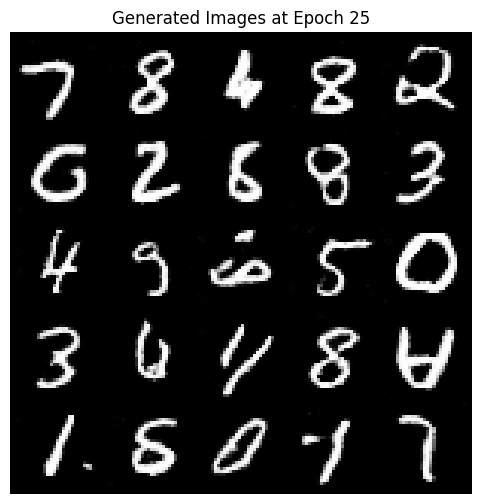

Epoch [26/50] | D Loss: 0.1243 | G Loss: 2.8936
Epoch [27/50] | D Loss: 0.2150 | G Loss: 1.1325
Epoch [28/50] | D Loss: 0.1118 | G Loss: 2.3473
Epoch [29/50] | D Loss: 0.1552 | G Loss: 2.6431
Epoch [30/50] | D Loss: 0.1028 | G Loss: 2.7497


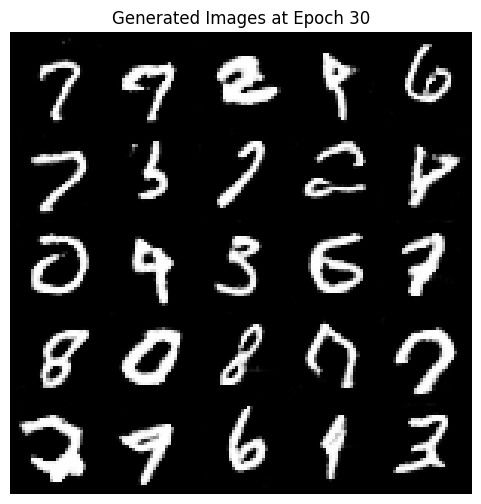

Epoch [31/50] | D Loss: 0.2626 | G Loss: 0.9243
Epoch [32/50] | D Loss: 0.1073 | G Loss: 3.9040
Epoch [33/50] | D Loss: 0.1367 | G Loss: 3.4577
Epoch [34/50] | D Loss: 0.0938 | G Loss: 3.3603
Epoch [35/50] | D Loss: 0.1004 | G Loss: 3.5666


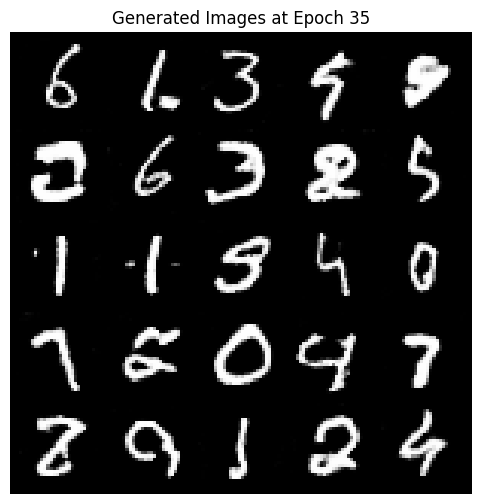

Epoch [36/50] | D Loss: 0.1668 | G Loss: 2.6973
Epoch [37/50] | D Loss: 0.0713 | G Loss: 3.3181
Epoch [38/50] | D Loss: 0.0500 | G Loss: 3.4336
Epoch [39/50] | D Loss: 0.1112 | G Loss: 2.2861
Epoch [40/50] | D Loss: 0.1231 | G Loss: 3.7031


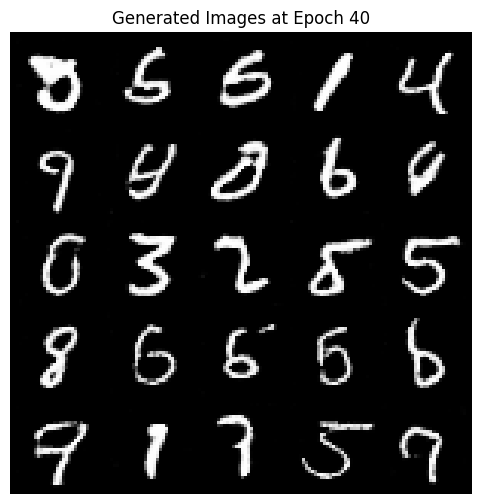

Epoch [41/50] | D Loss: 0.0826 | G Loss: 3.3655
Epoch [42/50] | D Loss: 0.1137 | G Loss: 2.6704
Epoch [43/50] | D Loss: 0.1001 | G Loss: 3.0330
Epoch [44/50] | D Loss: 0.1399 | G Loss: 1.7730
Epoch [45/50] | D Loss: 0.0768 | G Loss: 2.9680


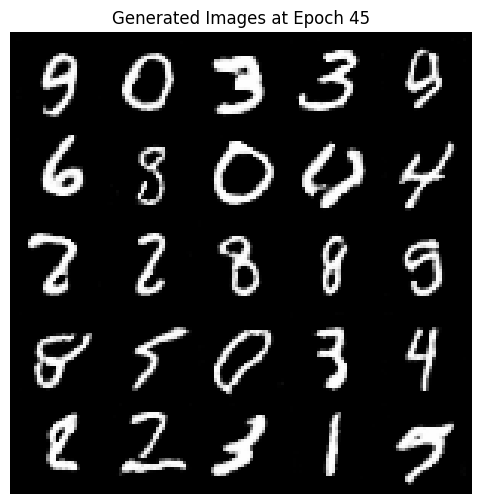

Epoch [46/50] | D Loss: 0.0562 | G Loss: 4.1741
Epoch [47/50] | D Loss: 0.1356 | G Loss: 3.8557
Epoch [48/50] | D Loss: 0.0806 | G Loss: 2.8468
Epoch [49/50] | D Loss: 0.0918 | G Loss: 2.9997
Epoch [50/50] | D Loss: 0.0842 | G Loss: 3.9315


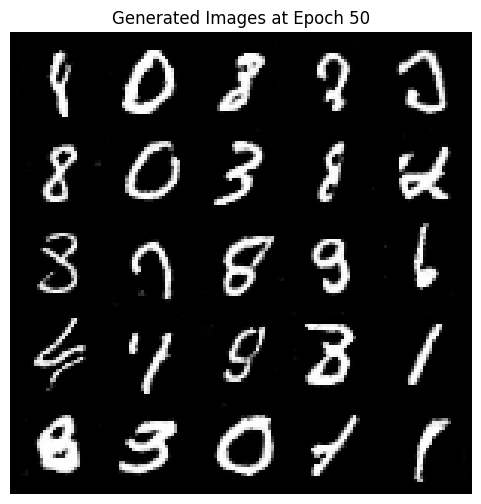

✅ Training Complete!


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

def train_gan(epochs, batch_size, sample_interval, z_dim, device):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_dataset = datasets.MNIST(root="dataset/", train=True, transform=transform, download=True)
    data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    generator = deep_gen(z_dim).to(device)
    discriminator = deep_disc(img_Shape=(1, 28, 28)).to(device)

    criterion = nn.BCELoss()
    opt_gen = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    opt_disc = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    losses = []

    print("🚀 Starting Training...")
    for epoch in range(epochs):
        for batch_idx, (real_imgs, _) in enumerate(data_loader):
            real_imgs = real_imgs.to(device)
            current_batch_size = real_imgs.size(0)

            real_labels = torch.ones(current_batch_size, 1).to(device)
            fake_labels = torch.zeros(current_batch_size, 1).to(device)

            discriminator.zero_grad()

            pred_real = discriminator(real_imgs)
            loss_d_real = criterion(pred_real, real_labels)

            noise = torch.randn(current_batch_size, z_dim).to(device)
            fake_imgs = generator(noise)
            pred_fake = discriminator(fake_imgs.detach())
            loss_d_fake = criterion(pred_fake, fake_labels)

            d_loss = (loss_d_real + loss_d_fake) / 2
            d_loss.backward()
            opt_disc.step()

            generator.zero_grad()

            output = discriminator(fake_imgs)
            g_loss = criterion(output, real_labels)

            g_loss.backward()
            opt_gen.step()

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}"
        )

        losses.append((d_loss.item(), g_loss.item()))

        if (epoch + 1) % sample_interval == 0:
            sample_images(generator, epoch + 1, z_dim, device)

    print("✅ Training Complete!")
    return losses

if __name__ == '__main__':
    EPOCHS = 50
    BATCH_SIZE = 128
    SAMPLE_INTERVAL = 5
    Z_DIM = 100
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    training_losses = train_gan(EPOCHS, BATCH_SIZE, SAMPLE_INTERVAL, Z_DIM, DEVICE)